# Build regression model
Created: 4/18/2021, Author: Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import pandas as pd
import glob
import pprint
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
import ipdb
import re
from src.formation import FormationCell
from src.utils import get_label_registry
from sklearn.model_selection import train_test_split

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Define the models

In [5]:
def build_model(x, y):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      x: inputs (single variable)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    model = LinearRegression()
    
    corr, _ = pearsonr(x.flatten(), y.flatten())
    
    model.fit(x.reshape(-1, 1), y)
    
    return (model, corr)
    

In [6]:
def train_and_test_model(x, y, to_plot=1):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      x and y are Pandas Series objects
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """
    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    NUM_EXPERIMENTS = 10000
    
    # Unpack and filter data
    x = df[xvar].values
    y = df[yvar].values
    
    idx_to_keep = ~np.isnan(x)
    x = np.array(x[idx_to_keep], dtype=float)
    y = np.array(y[idx_to_keep], dtype=float)
    
    x = x.reshape(-1, 1)
    
    percent_error_list = []
    rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(NUM_EXPERIMENTS):
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=TEST_SIZE)
    
        (model, corr) = build_model(x_train, y_train)

        model.predict(x_test)

        y_pred = model.predict(x_test)

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        intercept_list.append(model.intercept_)
        coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted:
            
            has_plotted = 1
            
            x_fit = np.linspace(np.min(x), np.max(x), 100)
            y_fit = model.predict(x_fit.reshape(-1, 1))
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(x_train, y_train, 'o', color='k')
            plt.plot(x_test, y_test, 's', color='r')
            
            for (this_x, this_y) in zip(x_test, y_test):
                plt.plot([this_x, this_x], 
                         [this_y, model.predict(this_x.reshape(-1,1))], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    final_model.coef_ = np.array([np.mean(coef_list)], dtype="object")
    final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_corr = np.mean(corr_list)
    final_corr_std = np.std(corr_list)
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    
    return model_output_dict

## Load the correlation data

In [7]:

path = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

df = pd.read_csv(path)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study
# a single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Keep only high temperature data / ignore room temperature data
df = df[df['is_room_temp_aging'] == 0]

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

<ipython-input-7-6ca9d118b1eb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-7-6ca9d118b1eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

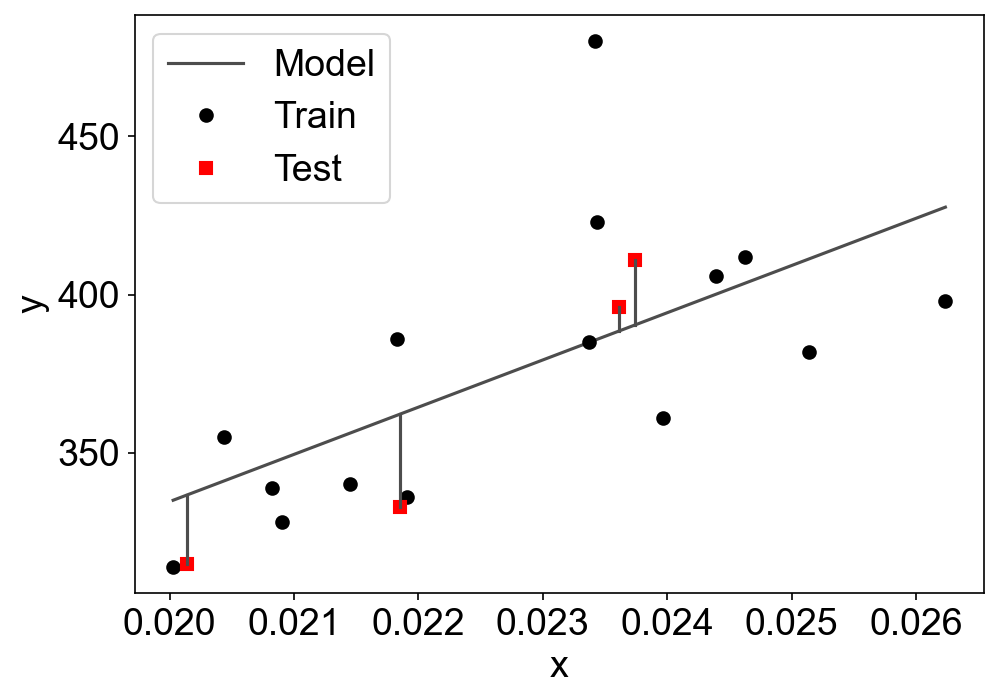

In [8]:
yvar = 'cycles_to_80_pct'

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'
x = df[xvar].values
y = df[yvar].values

idx_to_keep = ~np.isnan(x)
x = np.array(x[idx_to_keep], dtype=object)
y = np.array(y[idx_to_keep], dtype=object)

model_output_dict = train_and_test_model(df[xvar], df[yvar])
model = model_output_dict['model']

x_fit = np.linspace(np.min(df[xvar]), np.max(df[xvar]), 100)
y_fit = model.predict(x_fit.reshape(-1, 1))

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

In [9]:
# Preview the results list. The results are grouped by cycle number

Working on cycle 3...


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

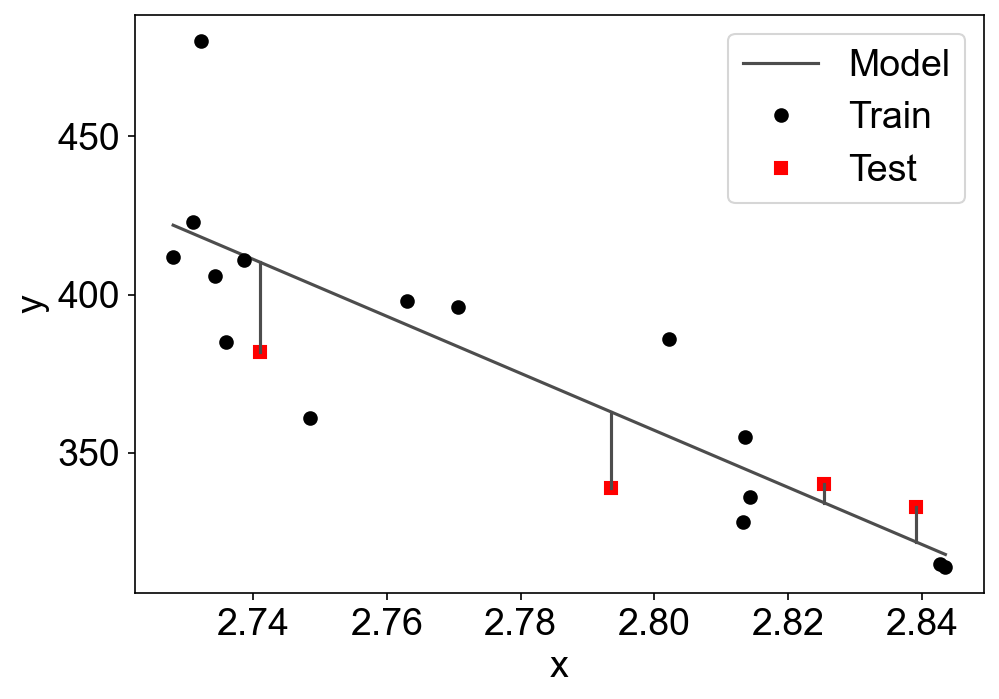

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

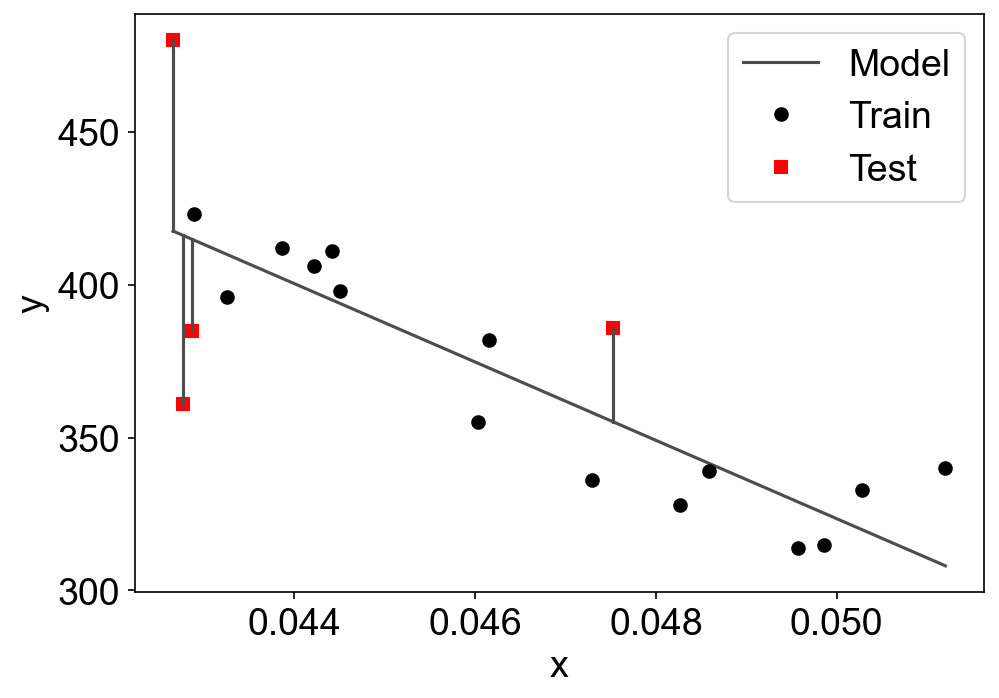

Working on cycle 56...


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

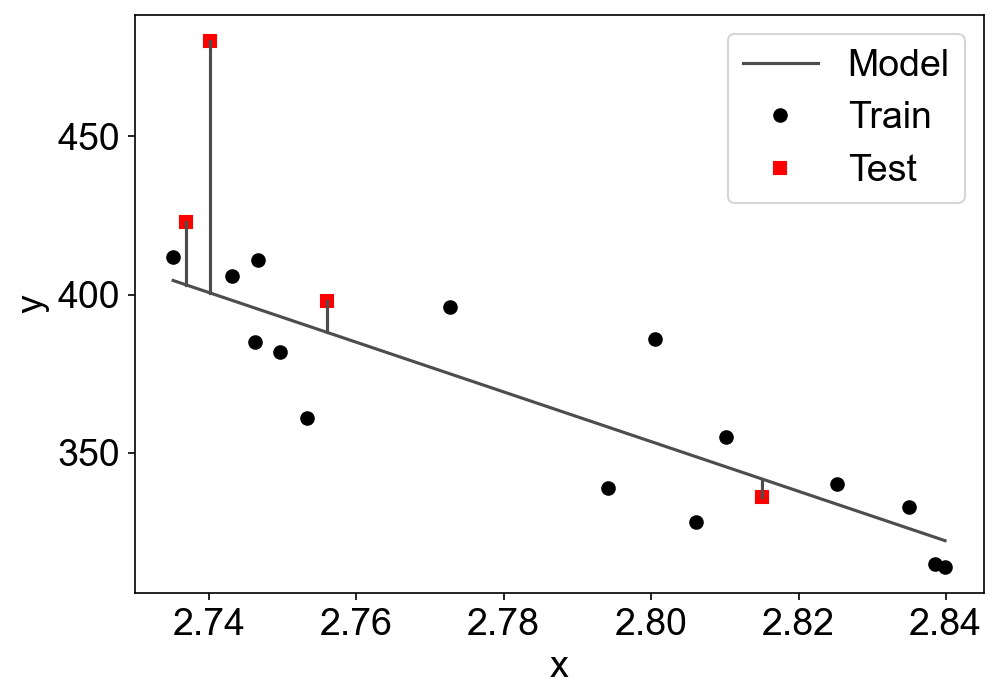

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

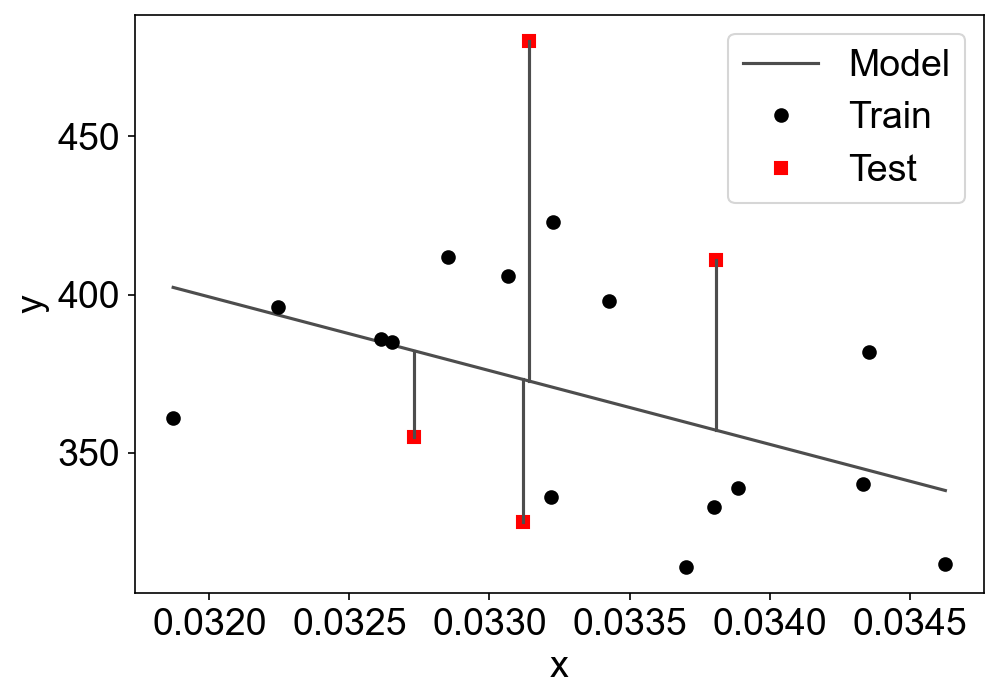

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

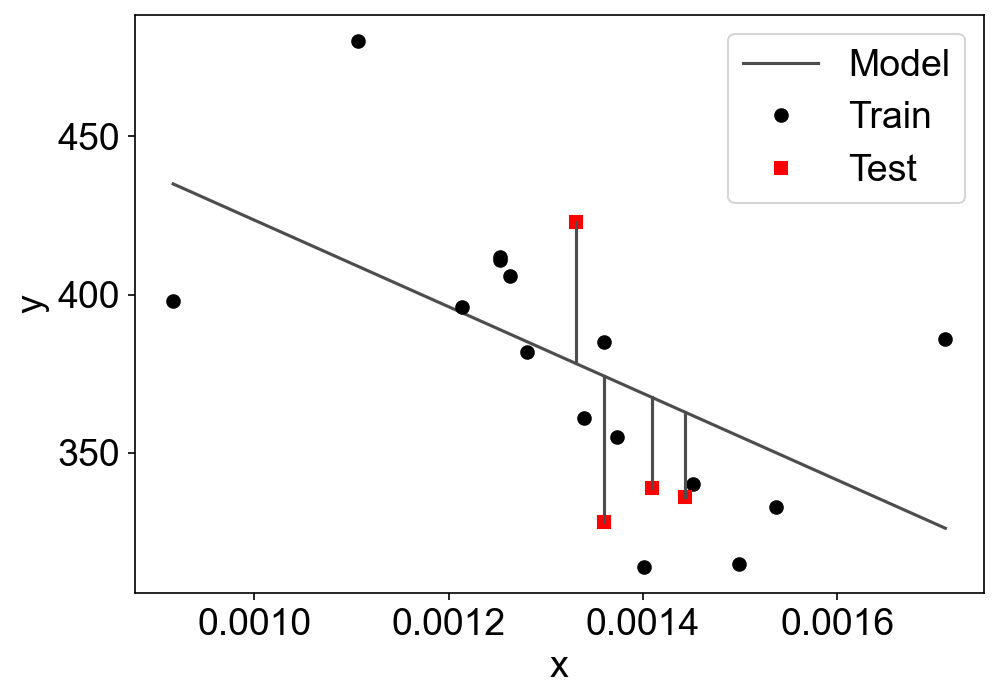

Working on cycle 159...


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

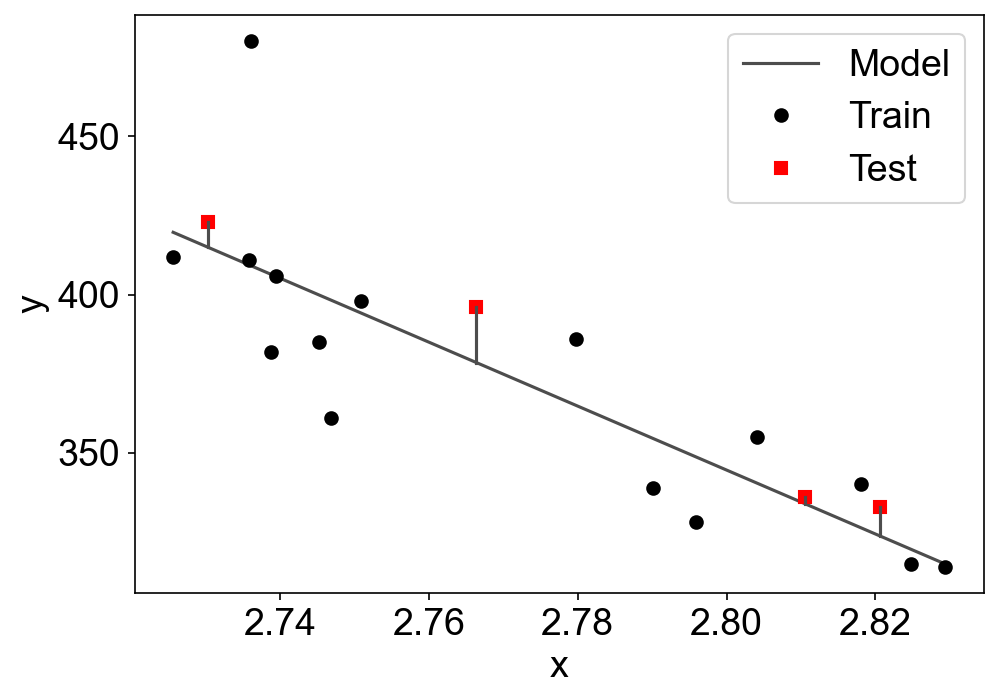

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

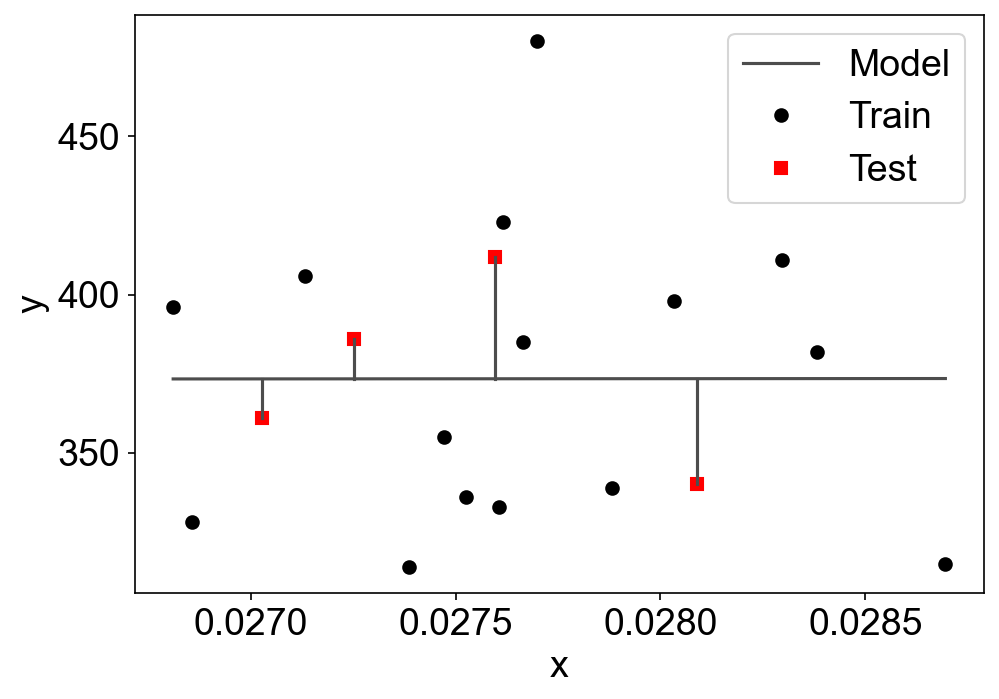

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

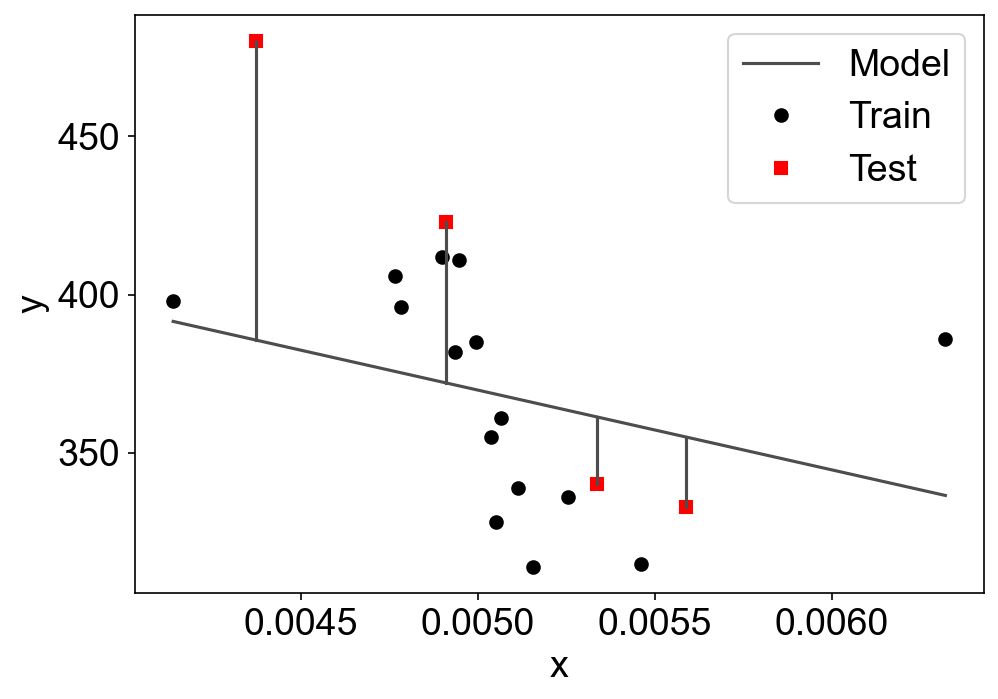

Working on cycle 262...


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

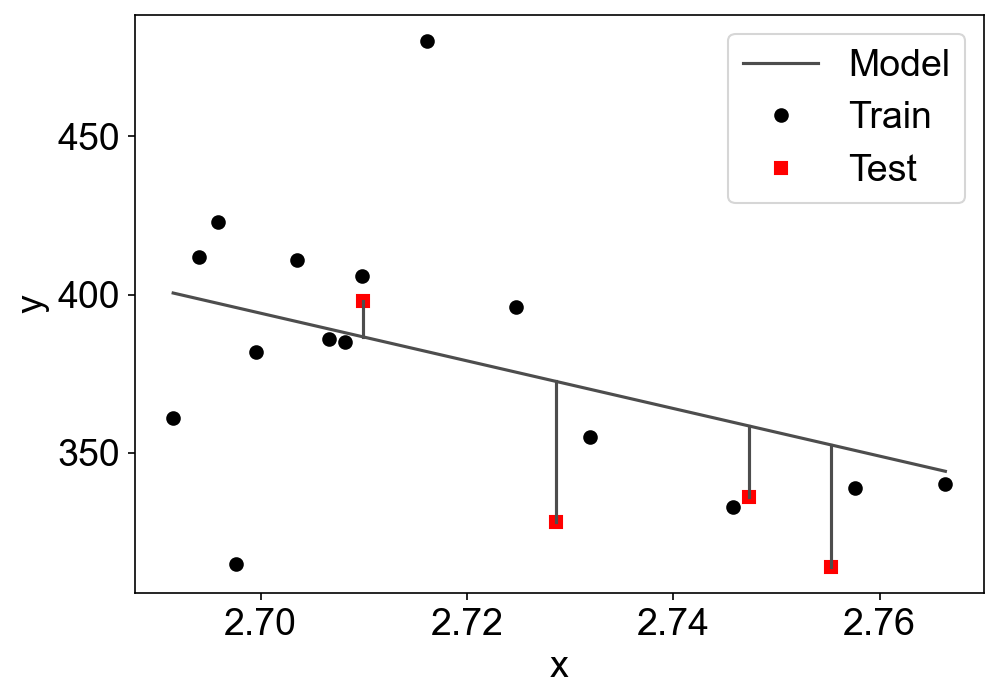

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

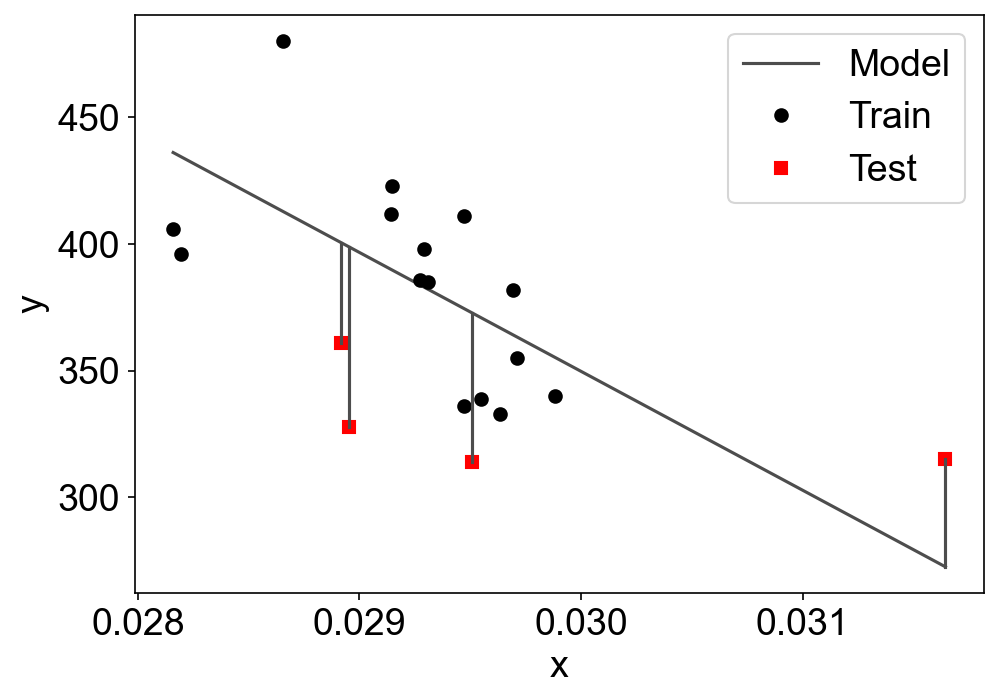

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

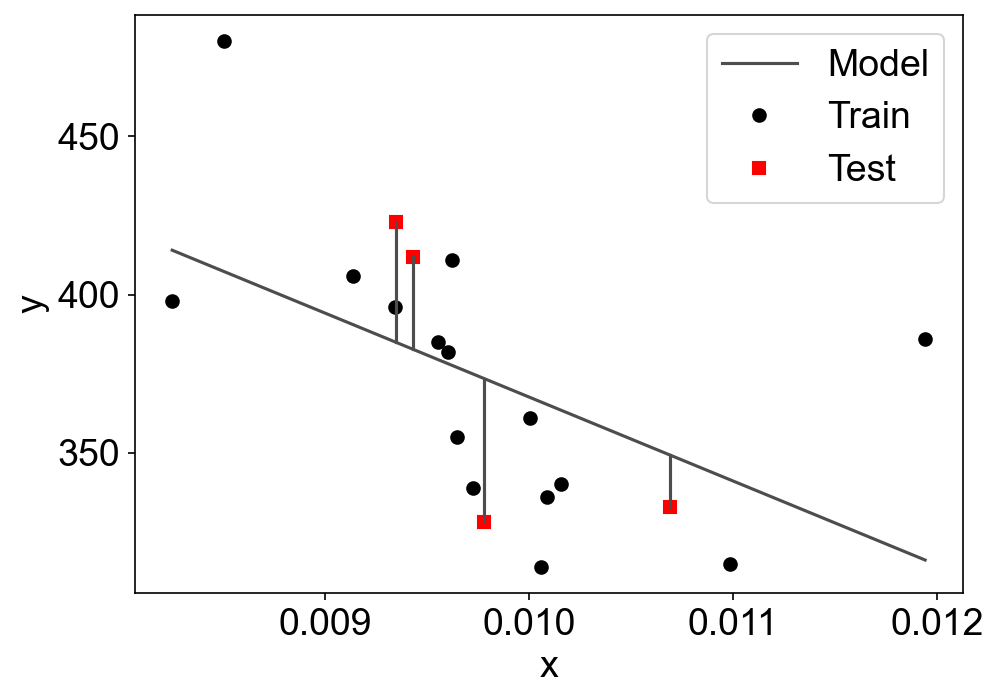

Working on cycle 365...


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

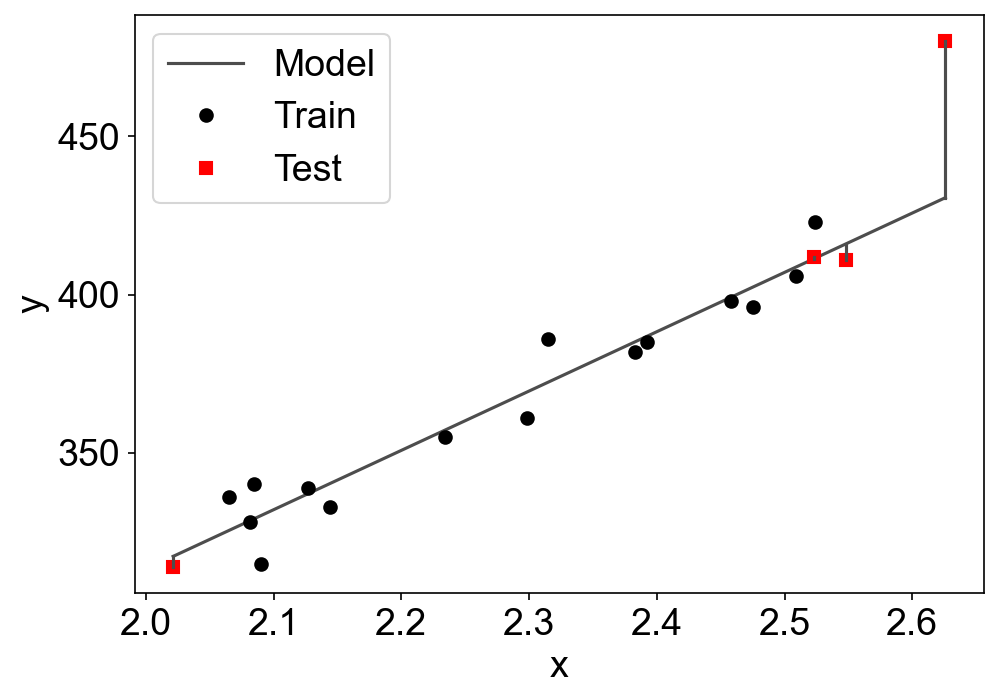

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

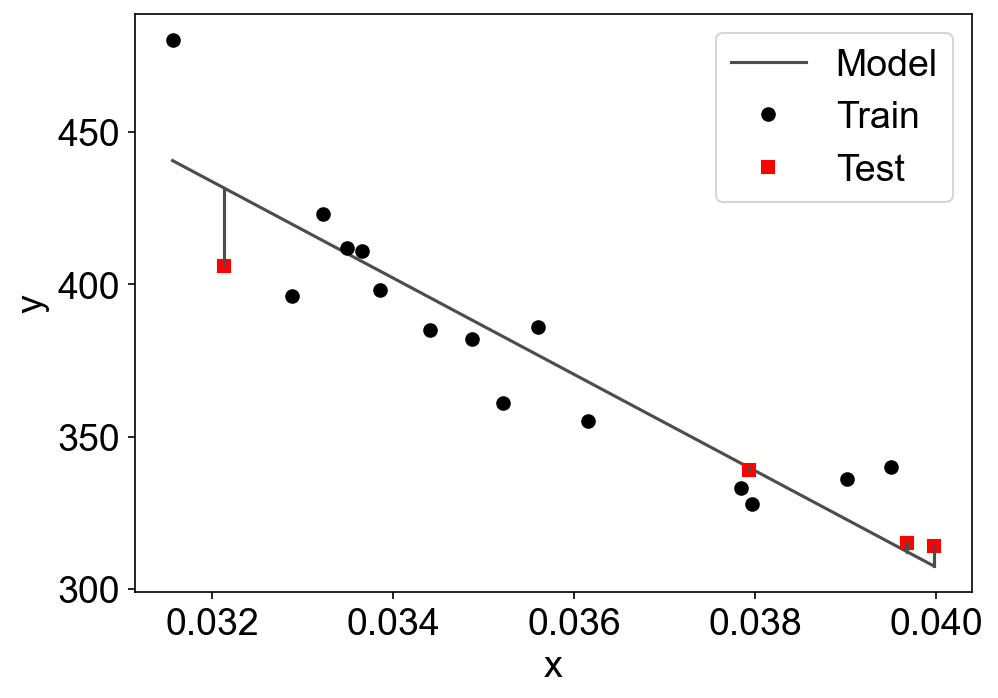

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating a

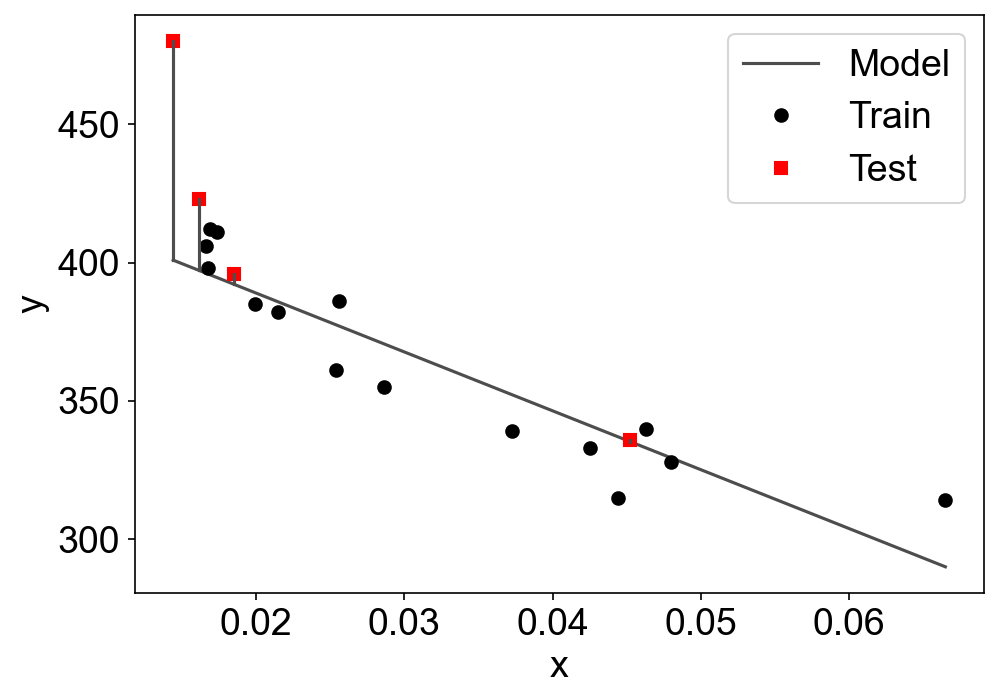

Done.


In [10]:
# Now take care of the rest
cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        x = df[xvar].values
        y = df[yvar].values

        idx_to_keep = ~np.isnan(x)
        x = np.array(x[idx_to_keep], dtype=object)
        y = np.array(y[idx_to_keep], dtype=object)

        model_output_dict = train_and_test_model(df[xvar], df[yvar])
        
        model = model_output_dict['model']
        x_fit = np.linspace(np.min(df[xvar]), np.max(df[xvar]), 100)
        y_fit = model.predict(x_fit.reshape(-1, 1))

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

# Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [11]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        corr_list.append(result_dict[key]['corr'])
        corr_std_list.append(result_dict[key]['corr_std'])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'var_q': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   nan,
   41.45203616893989,
   45.43303669075254,
   42.46454610948118,
   22.092168272092028],
  'rmse_std': [nan,
   nan,
   16.332947010048382,
   21.767290905440394,
   19.232604985931115,
   11.733631546910328],
  'corr': [nan,
   nan,
   -0.58406767887224,
   -0.5313823646934265,
   -0.5771725271312714,
   -0.8774177104377255],
  'corr_std': [nan,
   nan,
   0.09693044930452044,
   0.13770312040687244,
   0.12597097516204983,
   0.028700334071915575],
  'percent_error': [nan,
   nan,
   9.153075537614317,
   9.901559520080792,
   9.259615522444905,
   4.562309964359294],
  'percent_error_std': [nan,
   nan,
   3.2741248319841776,
   3.89696978325717,
   3.481803644588976,
   2.1430096235563076]},
 'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   27.233468399755385,
   42.48958367484508,
   45.95571826208285,
   38.20811361411874,
   16.99088892217269],
  'rmse_std': [nan,
   10.75

# Visualize the results

In [12]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

<Figure size 1050x750 with 0 Axes>

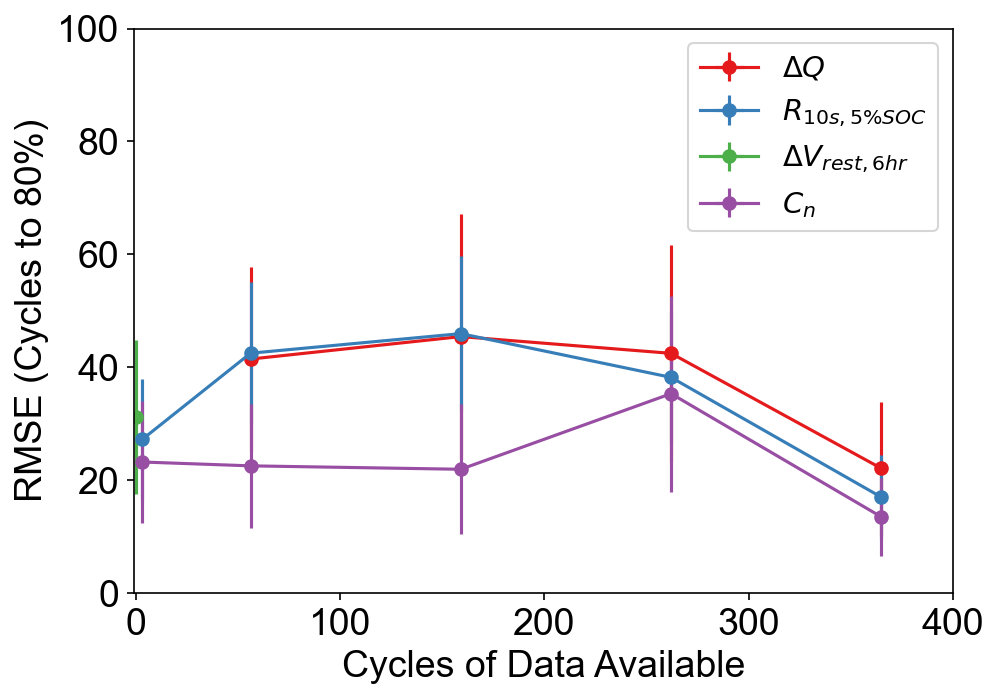

<Figure size 1050x750 with 0 Axes>

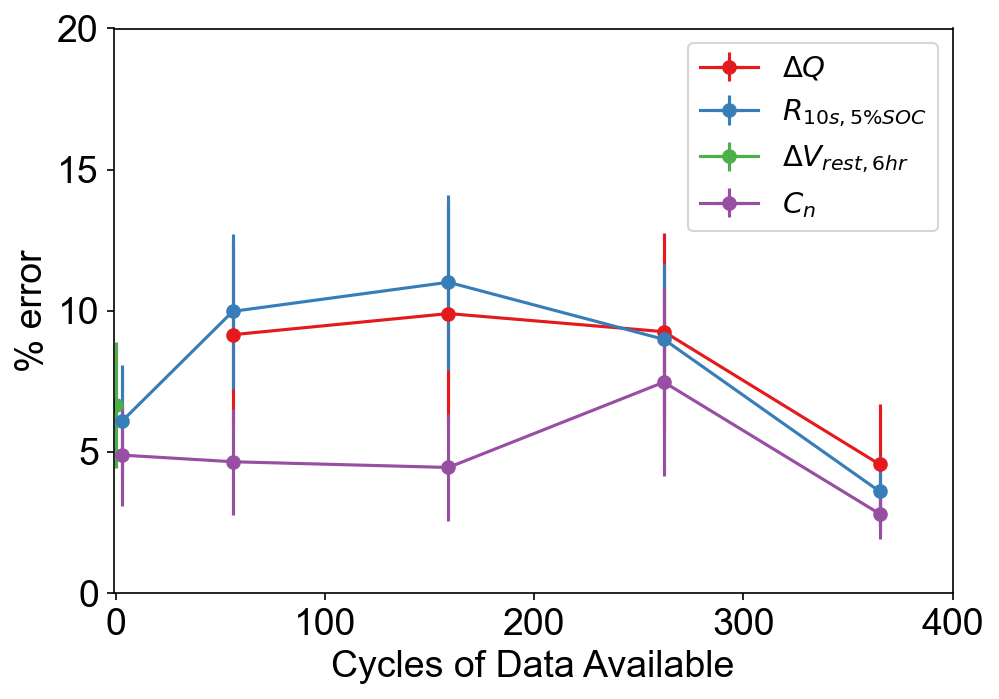

<Figure size 1050x750 with 0 Axes>

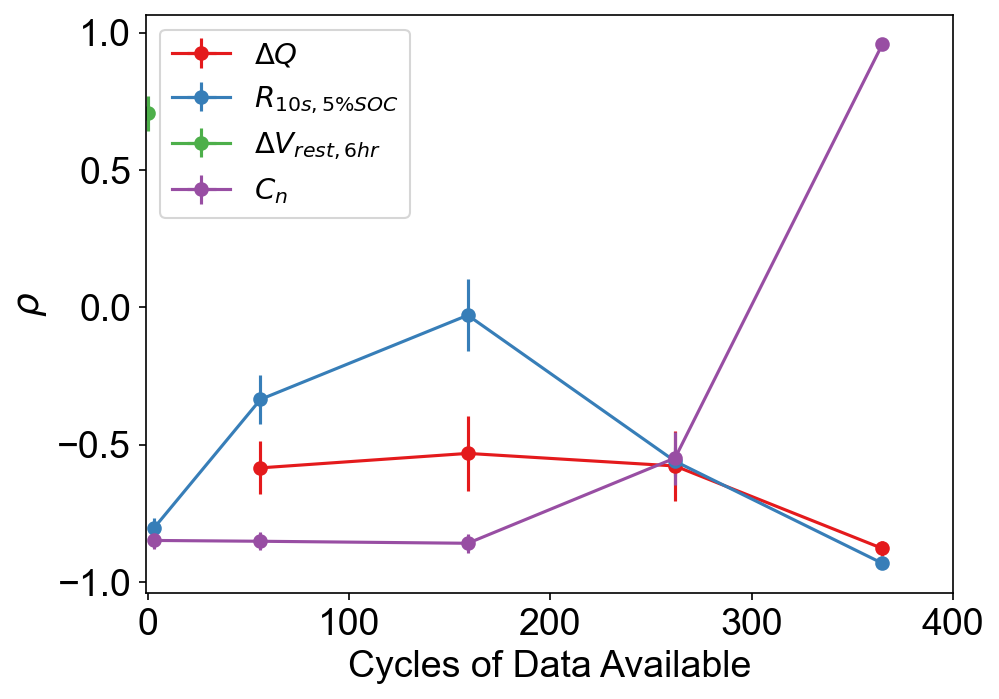

In [13]:
# Unpack and plot the dictionary of outputs
plt.figure()
fig, ax = plt.subplots()

labels = ["c%.0f" % number for number in output_dict[list(output_dict.keys())[0]]['cycle_index']]
labels[0] = "         Form."
    
# RMSE error (cycles to 70%)
for idx, key in enumerate(output_dict):

    x = output_dict[key]['cycle_index']
    y = output_dict[key]['rmse']
    error = output_dict[key]['rmse_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('RMSE (Cycles to 80%)')
plt.xlim((-1, 400))
plt.ylim((0, 100))
plt.legend(fontsize=14)

# Percent error
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['percent_error']
    error = output_dict[key]['percent_error_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('% error')
plt.ylim((0, 20))
plt.xlim((-1, 400))
plt.legend(fontsize=14)


# Correlation coefficient evolution
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['corr']
    error = output_dict[key]['corr_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel(r'$\rho$')
plt.xlim((-1, 400))
plt.legend(fontsize=14)

